This is an inference notebook for the SIFAIC model.

In [1]:
import os

# Set the environment variables to specify the cache directories
# for different libraries or frameworks.
os.environ['XDG_CACHE_HOME'] = '/home/msds2023/javila/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/msds2023/javila/.cache'
os.environ['TRANSFORMERS_CACHE'] = '/home/msds2023/javila/.cache'

In [2]:
import gradio as gr

In [3]:
import PIL
from PIL import Image
import os, shutil
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import copy
import time

import torch
import torchvision
from torchvision.utils import save_image
from torchvision.transforms.functional import to_tensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

import lime
from lime import lime_image

In [4]:
# Hoping there is a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# Load pre-trained ResNet18 model
model =  torchvision.models.resnet34(weights='IMAGENET1K_V1')

num_classes = 30

# Modify the classifier layers
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)

# Setting parameters to fine-tune
params_to_update = ['layer4.0.conv1.weight', 'layer4.0.conv1.bias',
                    'layer4.0.conv2.weight', 'layer4.0.conv2.bias',
                    'layer4.1.conv1.weight', 'layer4.1.conv1.bias',
                    'layer4.1.conv2.weight', 'layer4.1.conv2.bias',
                    'fc.weight', 'fc.bias']

# Store parameters in a list
params = []
for name, param in model.named_parameters():
    for parameter in params_to_update:
        if parameter in name:
            param.requires_grad = True
            params.append(param)

# Replace last fully connected layer to match the number of output classes
model.fc = nn.Linear(512, num_classes)

In [7]:
# Load the saved model weights
model.load_state_dict(torch.load('SIFAIC.pth'))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 21300062


In [9]:
import torch.nn.functional as F

def predict_image(test_image, model, show_image=False):
    """
    Predicts the class of a test image using a trained model and
    calculates the similarity between the test image
    and the training images of the predicted class.

    Args:
        test_image (PIL.Image): The test image to predict the class for.
        model (torch.nn.Module): The trained model to use for prediction.
        show_image (bool, optional): Whether to display the test image
        along with its predicted class. Default is False.

    Returns:
        tuple or None: If `show_image` is False, returns a tuple
        containing the predicted class and the similarity 
        scores. If `show_image` is True, displays the test image with
        its predicted class and similarity score, and returns None.
    """
    means = [0.3993528, 0.4104297, 0.36928317]
    stds = [0.20810837, 0.18451604, 0.18224896]
    classes = ['Airport',
                 'BareLand',
                 'BaseballField',
                 'Beach',
                 'Bridge',
                 'Center',
                 'Church',
                 'Commercial',
                 'DenseResidential',
                 'Desert',
                 'Farmland',
                 'Forest',
                 'Industrial',
                 'Meadow',
                 'MediumResidential',
                 'Mountain',
                 'Park',
                 'Parking',
                 'Playground',
                 'Pond',
                 'Port',
                 'RailwayStation',
                 'Resort',
                 'River',
                 'School',
                 'SparseResidential',
                 'Square',
                 'Stadium',
                 'StorageTanks',
                 'Viaduct']
        # Preprocess the image
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    test_img = test_transform(test_image)
    test_img = test_img.unsqueeze(0)
    with torch.no_grad():
        test_img = test_img.to(device)
        output = model(test_img)
        probabilities = F.softmax(output, dim=1)
        _, predicted = torch.max(output, dim=1)
    
    pclass = classes[predicted]

    if show_image == True:
        # Create a figure and subplots
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

        # Plot the image
        ax.imshow(test_image)
        ax.axis('off')

        # Set the title as the corresponding class
        ax.set_title(f"{pclass} ({probabilities[0, predicted].item()*100:.4f} %)")
    else:
        return pclass, probabilities

In [10]:
img_fname = "flooded_residential_testimage.jpg"
test_image2 = Image.open(img_fname)

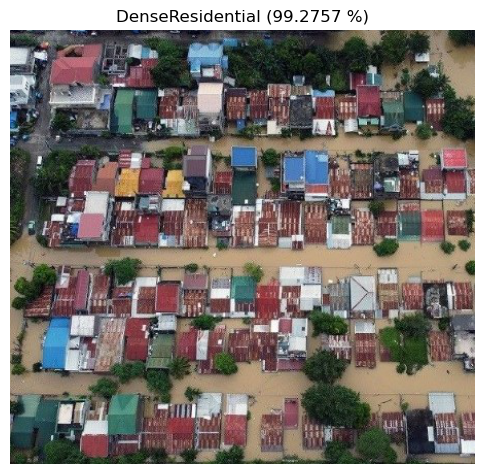

In [11]:
predict_image(test_image2, model, show_image=True)

In [12]:
def explainer(test_img):  
    means = [0.3993528, 0.4104297, 0.36928317]
    stds = [0.20810837, 0.18451604, 0.18224896]
    classes = ['Airport',
                 'BareLand',
                 'BaseballField',
                 'Beach',
                 'Bridge',
                 'Center',
                 'Church',
                 'Commercial',
                 'DenseResidential',
                 'Desert',
                 'Farmland',
                 'Forest',
                 'Industrial',
                 'Meadow',
                 'MediumResidential',
                 'Mountain',
                 'Park',
                 'Parking',
                 'Playground',
                 'Pond',
                 'Port',
                 'RailwayStation',
                 'Resort',
                 'River',
                 'School',
                 'SparseResidential',
                 'Square',
                 'Stadium',
                 'StorageTanks',
                 'Viaduct']
    
       # Preprocess the image
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
    test_img = test_transform(test_img)
    input_tensor = test_img.unsqueeze(0).to(device)

    # Perform the forward pass on the ResNet model
    with torch.no_grad():
        output = model(input_tensor)

    # Convert the PyTorch output tensor to a numpy array
    output_np = output.cpu().numpy()

    # Reshape the input tensor to a 2D color image format
    input_2d = np.transpose(input_tensor.squeeze().cpu().numpy(), (1, 2, 0))

    # Perform Lime explanations
    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(input_2d,
                                     classifier_fn=(lambda imgs:
                                                    model(torch.Tensor
                                                          (np.transpose
                                                    (imgs, (0, 3, 1, 2)))
                                                          .to(device))
                                                    .detach()
                                                    .cpu().numpy()),
                                     top_labels=5,
                                     hide_color=0,
                                     num_samples=1000)
    return exp

In [13]:
exp = explainer(test_image2)

  0%|          | 0/1000 [00:00<?, ?it/s]

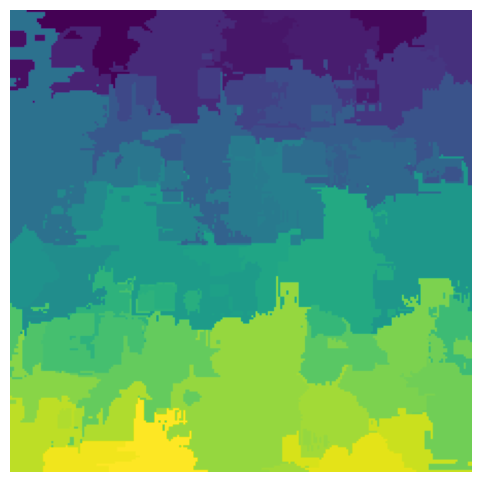

In [14]:
fig = plt.figure(figsize=(6, 6))
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [18]:
from io import BytesIO

def generate_prediction_sample(exp,
                               exp_class,
                               weight=0,
                               show_positive=True,
                               hide_background=True,
                               test_image=None):
    """
    Method to display and highlight super-pixels used by
    the black-box model to make predictions
    """
    # Generate the image and mask based on LIME explanations
    image, mask = exp.get_image_and_mask(exp_class,
                                     positive_only=show_positive,
                                     num_features=20,
                                     hide_rest=hide_background,
                                     min_weight=weight)
    
    # Get the original image without any processing applied
    original_image = test_image
    
    # Change the color of the boundary and outside area to gray
    # Set color=(0, 0, 0) for black, and outline_color=(0.5, 0.5, 0.5)
    # for gray
    boundaries = mark_boundaries(image,
                                 mask,
                                 color=(0, 0, 0),
                                 outline_color=(0.5, 0.5, 0.5))
    
    # Set boundary and outside area to gray (0.5), and keep other values
    gray_outside = np.where(boundaries == 0, 0.5, boundaries)  
    
    # Create a figure with two subplots: original image
    # and gray_outside image
    fig, axs = plt.subplots(1, 2, figsize=(6, 6))

    # Display the original image
    axs[0].imshow(original_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Display the gray_outside image
    axs[1].imshow(gray_outside)
    axs[1].axis('off')
    if hide_background:
        axs[1].set_title('Superpixels Used by Model')
    else:
        axs[1].set_title('Superpixels Used by LIME')

    plt.tight_layout()
    
    # Save the plot as a PIL image
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    result_image = Image.open(img_buffer)
    
    plt.close()
    
    return result_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


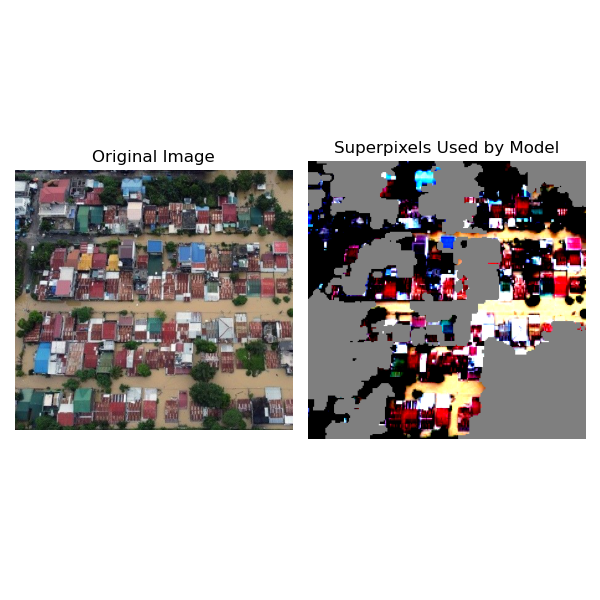

In [19]:
from skimage.segmentation import mark_boundaries

generate_prediction_sample(exp, exp.top_labels[0],
                           show_positive=True,
                           hide_background=True,
                           test_image=test_image2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


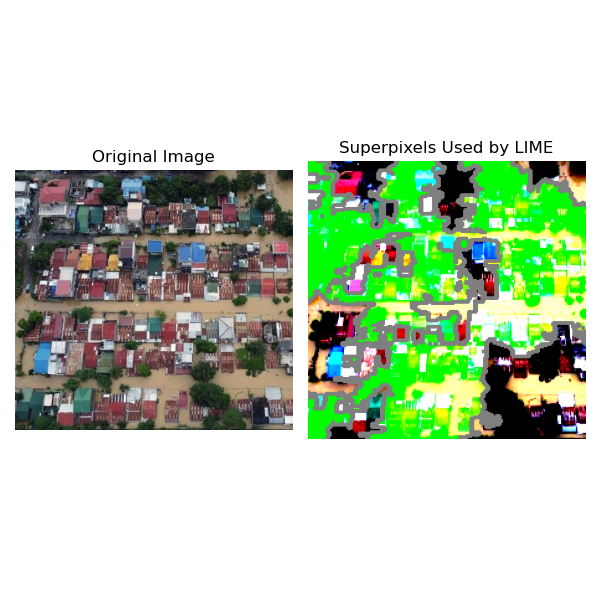

In [20]:
generate_prediction_sample(exp, exp.top_labels[0],
                           show_positive=False,
                           hide_background=False,
                           test_image=test_image2)

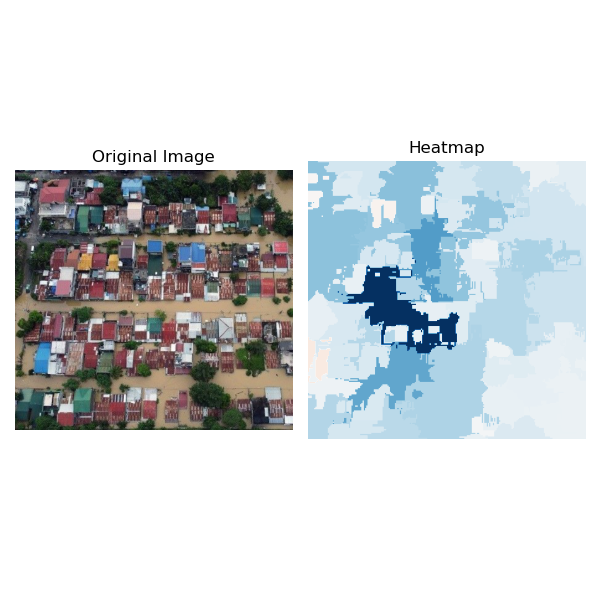

In [23]:
def explanation_heatmap(exp, exp_class, test_image):
    """
    Using heat-map to highlight the importance of each super-pixel
    for the model prediction
    """
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    
    # Create a figure with two subplots: original image and heatmap
    fig, axs = plt.subplots(1, 2, figsize=(6, 6))

    # Display the original image
    axs[0].imshow(test_image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Display the heatmap
    axs[1].imshow(heatmap, cmap='RdBu',
                  vmin=-heatmap.max(),
                  vmax=heatmap.max())
    axs[1].axis('off')
    axs[1].set_title('Heatmap')

    plt.tight_layout()
    
    # Save the plot as a PIL image
    img_buffer = BytesIO()
    plt.savefig(img_buffer, format='png')
    img_buffer.seek(0)
    heatmap_image = Image.open(img_buffer)
    
    plt.close()
    
    return heatmap_image

explanation_heatmap(exp, exp.top_labels[0], test_image2)

In [24]:
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

def predict(input_image):
    # Convert Gradio image format to PIL image
    test_image = Image.fromarray(input_image)
    
    # Perform prediction and generate plots
    prediction = predict_image(test_image, model)
    exp = explainer(test_image)
    image1 = generate_prediction_sample(exp, exp.top_labels[0],
                                        show_positive=True,
                                        hide_background=True)
    image2 = generate_prediction_sample(exp, exp.top_labels[0],
                                        show_positive=False,
                                        hide_background=False)
    image3 = explanation_heatmap(exp, exp.top_labels[0])
    
    return [f"Prediction: {prediction}", image1, image2, image3]

# Define Gradio interface with text instructions
inputs = gr.inputs.Image()
outputs = [gr.outputs.Textbox(label="Model Prediction"),
           gr.outputs.Image(label="Superpixels Used by Model",
                            type="pil"), 
           gr.outputs.Image(label="Superpixels Used by LIME",
                            type="pil"), 
           gr.outputs.Image(label="LIME's Pixels Weight Assignment",
                            type="pil")]

title = "Superpixel Insights for Aerial Image Classification (SIFAIC)"
description = "This interface uses LIME (Local Interpretable Model-agnostic Explanations) to identify the most important superpixels contributing to the model's prediction.\n\nPlease use aerial scenic images from Google Earth in JPEG or JPG format, with a size of 600 x 600 pixels for better model accuracy.\n\nThe supported class list for images includes:\n\nAirport, BareLand, BaseballField, Beach, Bridge, Center, Church, Commercial, DenseResidential, Desert,\nFarmland, Forest, Industrial, Meadow, MediumResidential, Mountain, Park, Parking, Playground, Pond,\nPort, RailwayStation, Resort, River, School, SparseResidential, Square, Stadium, StorageTanks, Viaduct.\n\nEnjoy! :)"

gr_interface = gr.Interface(fn=predict, inputs=inputs, outputs=outputs, title=title, description=description)
gr_interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7867
Running on public URL: https://394b8096d4e866d460.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
